# export_seasonal_annual_data

Author: Marco A. Franco
Contact: marco.franco@usp.br

Description:
This script processes annual average climate and atmospheric composition data (e.g., temperature, precipitation,
greenhouse gases) for a given Amazonian study area. It aggregates data from remote sensing sources (ERA5, GPM,
AIRS, OCO-2) and exports yearly average values for the total year, wet season, and dry season.

Key Outputs:
- CSV files containing yearly average data for Total, Wet, and Dry seasons
- Diagnostic plots of trends and seasonal cycles

Data Requirements (organized by area):
- ERA5 CSVs: /Total_Area/ERA5/*.csv
- AIRS CH4: /Total_Area/AIRS/CH4/methane.csv
- AIRS CO: /Total_Area/AIRS/CO/CO_<Area>.csv
- OCO-2 CO2: /Total_Area/OCO2/CO2/CO2_<Area>.csv
- GPM: /Total_Area/GPM/GPM_Total_2000_2020.csv
- Forest fraction: /fraction_forest.csv

In [11]:
%reset

import matplotlib.pyplot as plt
from sklearn import linear_model
import pylab
from scipy import signal
import seaborn as sns
from datetime import date
from datetime import datetime
import statsmodels.api as sm
import warnings
import pandas as pd
import datetime
import time
import glob
import numpy as np
import math 
import os

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


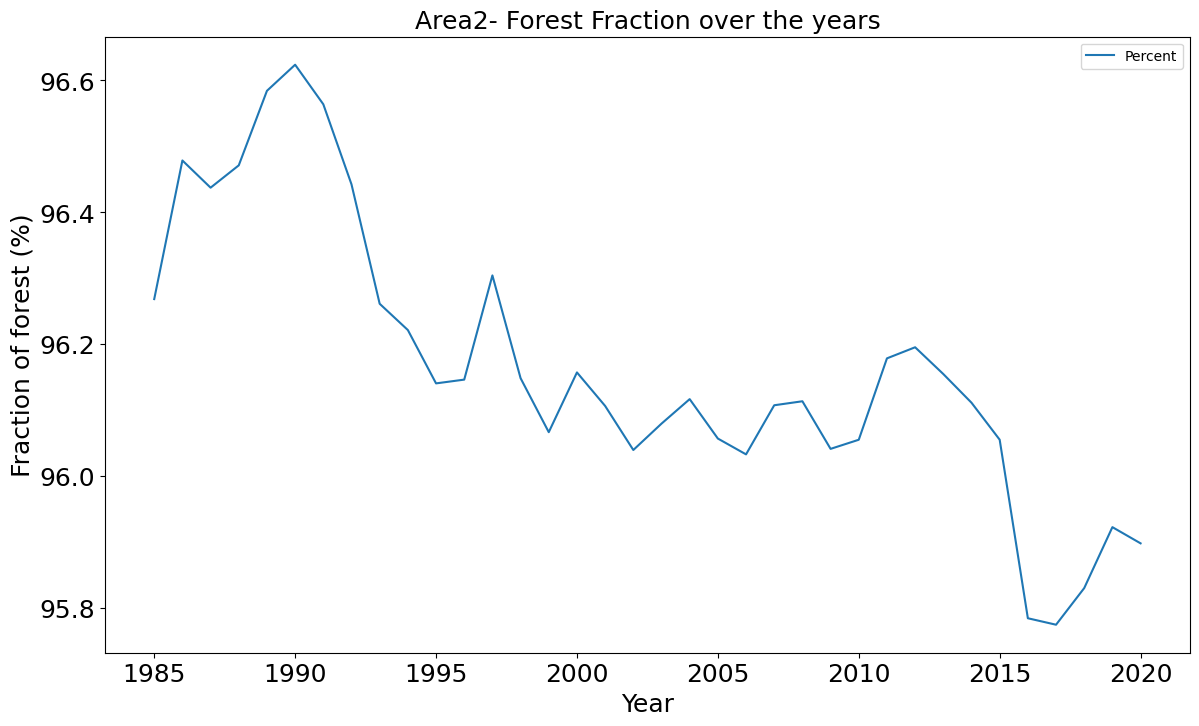

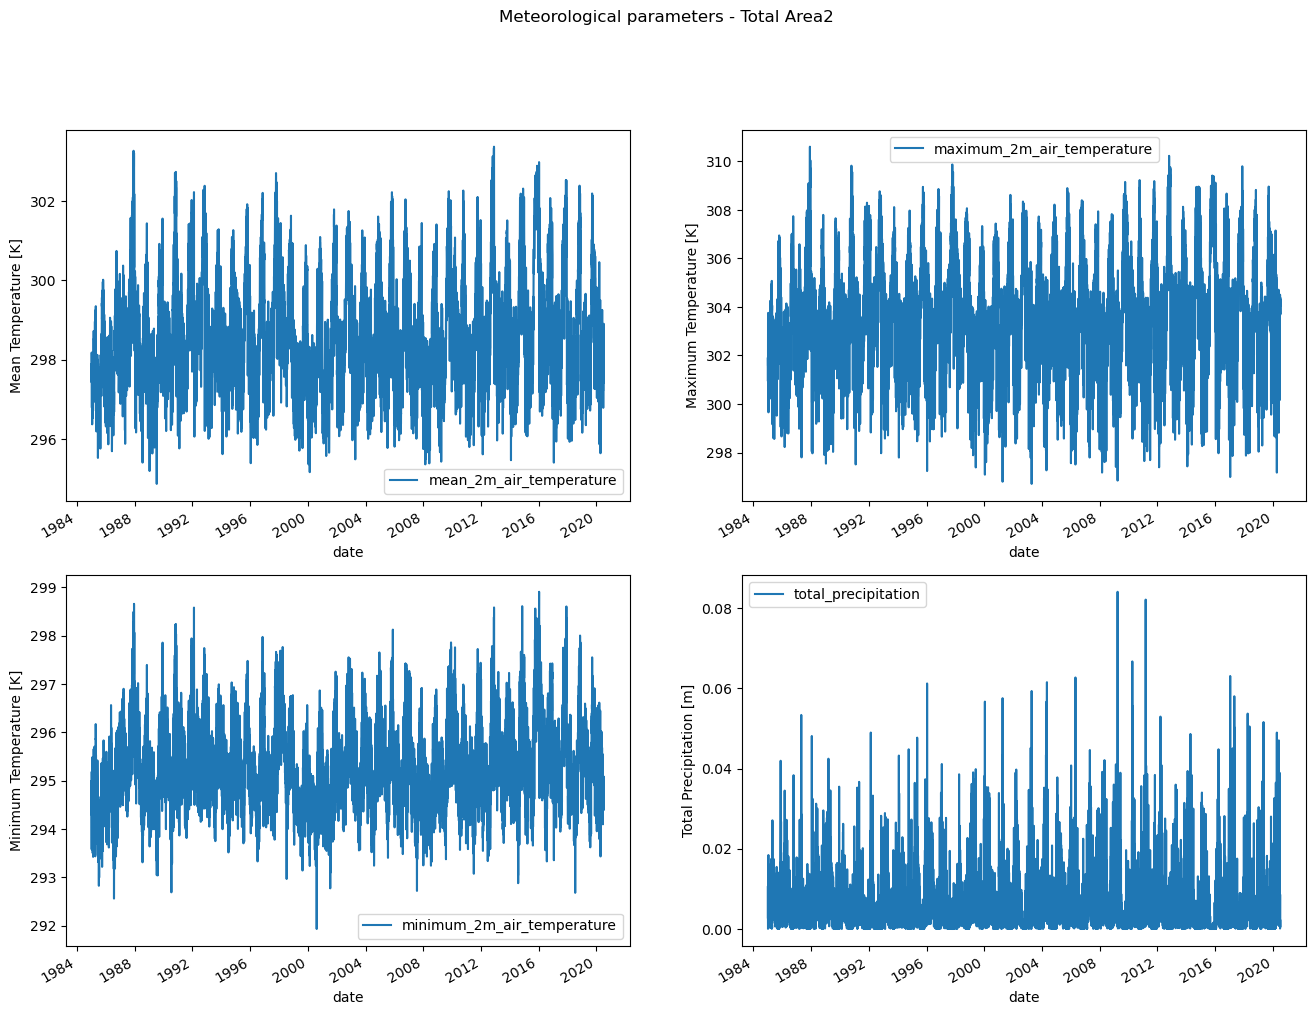

date
1      7.674696
2      8.124127
3     10.018358
4     12.068753
5     11.255622
6      6.314949
7      4.580695
8      2.651694
9      2.175784
10     2.599802
11     3.503351
12     4.861381
Name: total_precipitation, dtype: float64
[1, 2, 3, 4]
[7, 8, 9, 10]
Wet Season: 2 to 5
Dry Season: 8 to 11


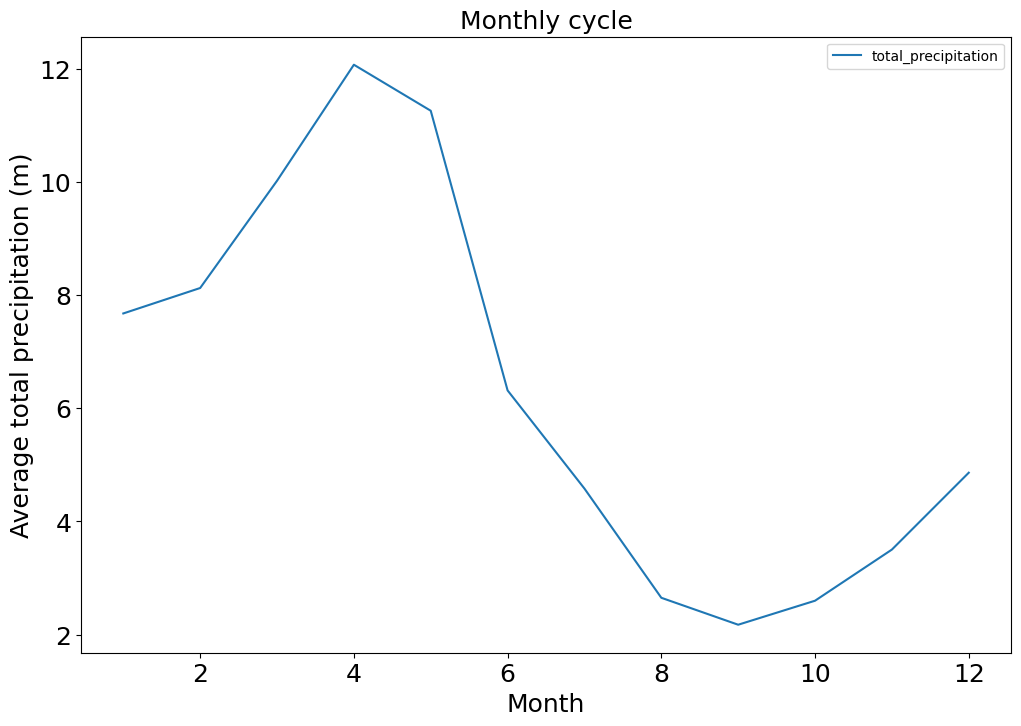

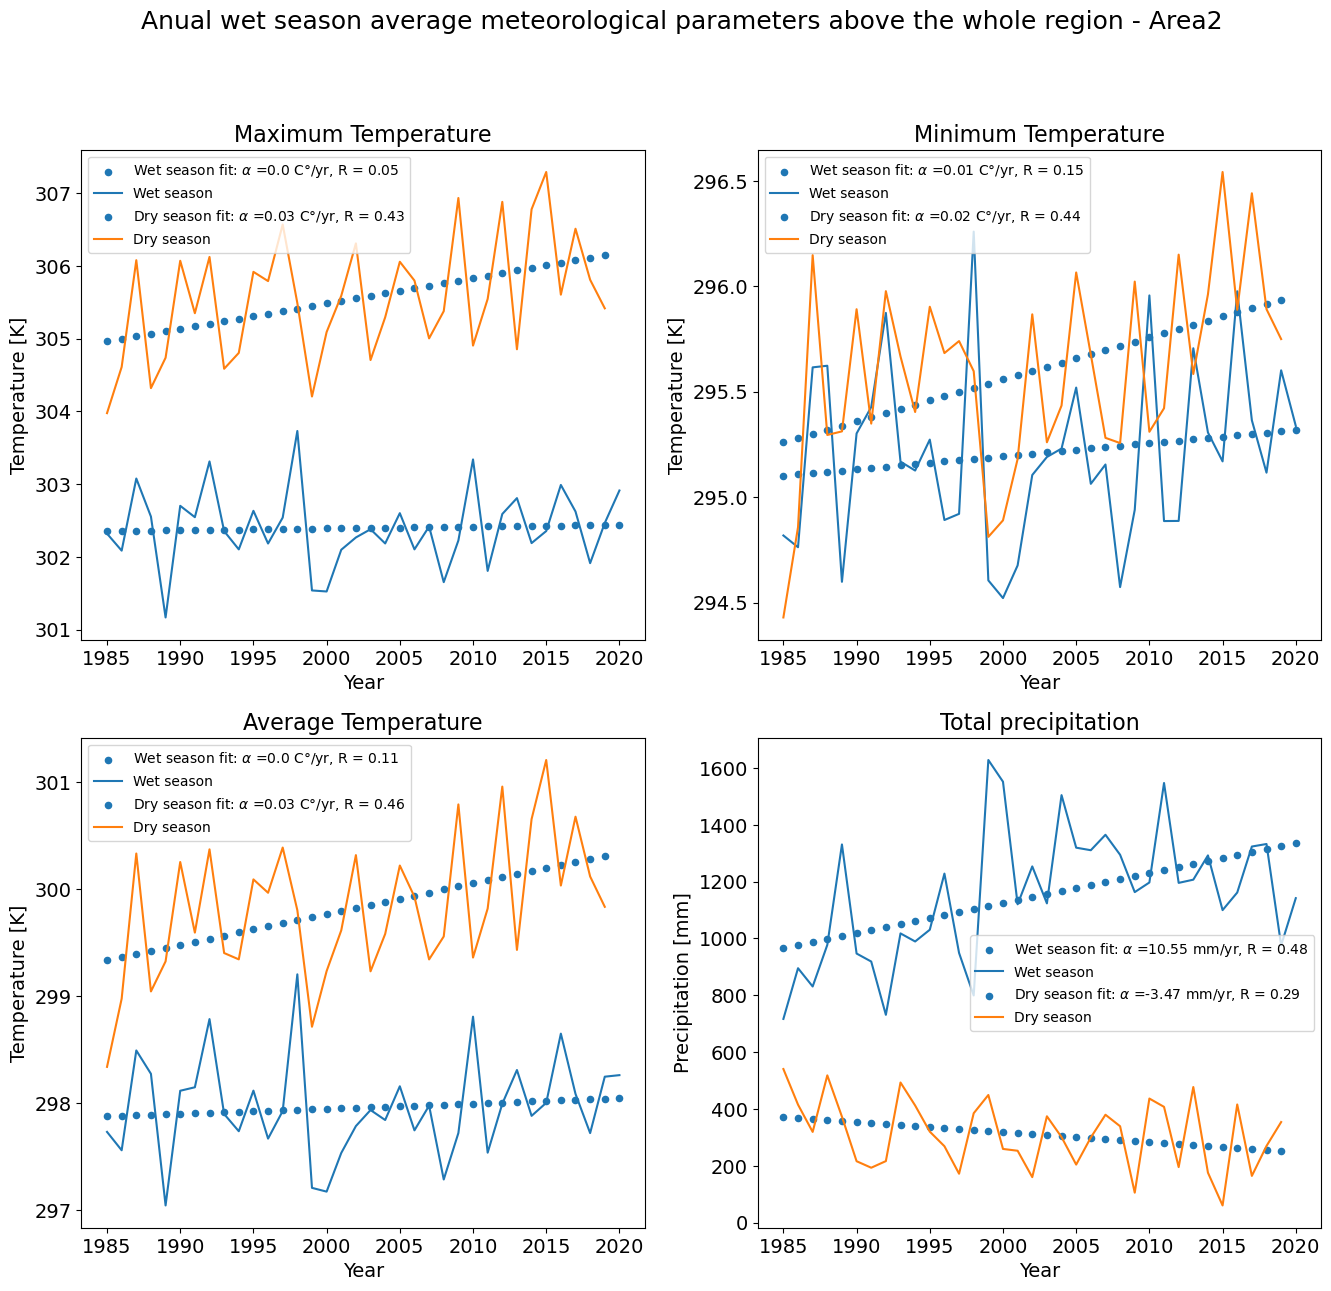

Exported!


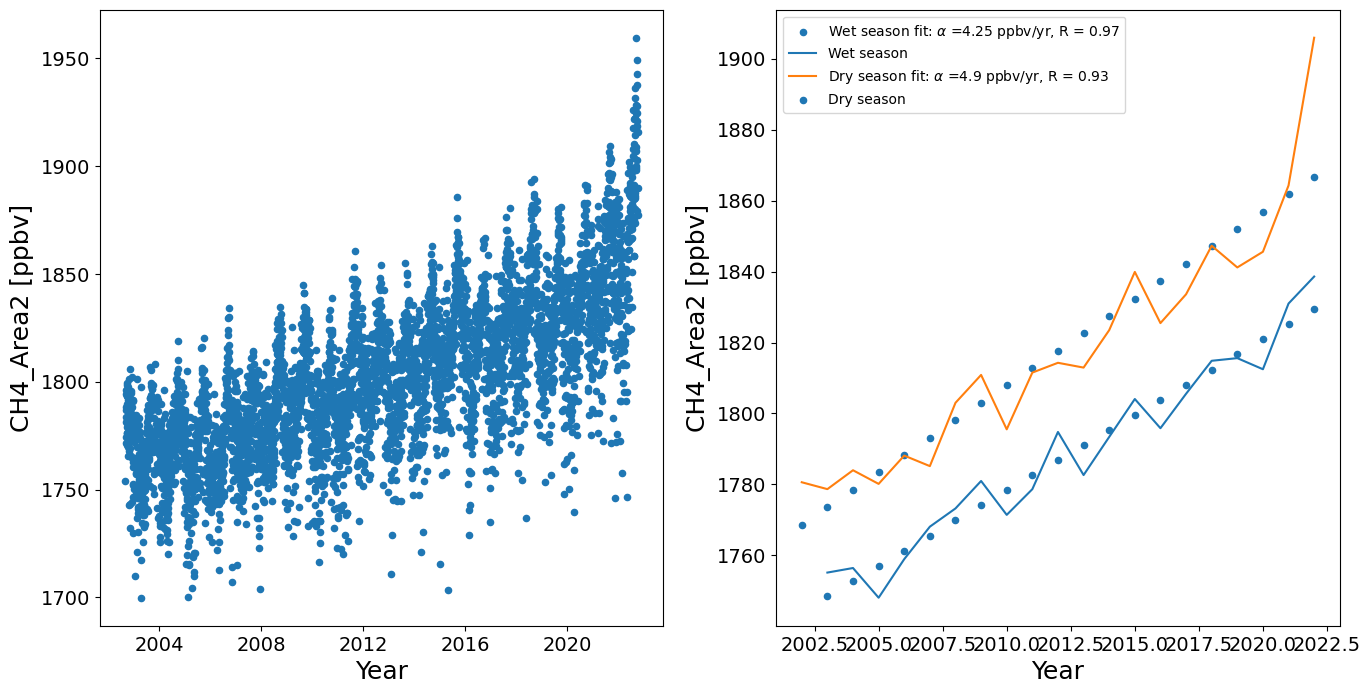

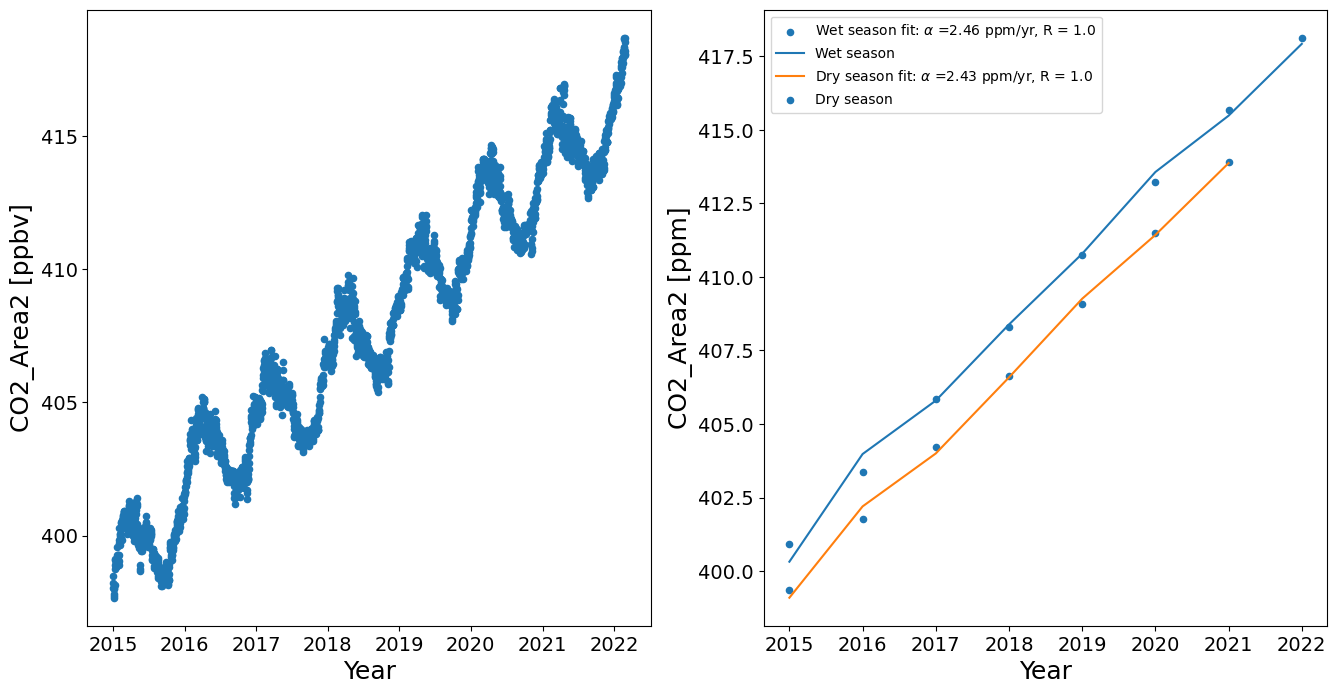

In [13]:
# Load forest fraction time series for the selected study area
area = 'Area2'  # Change this to select the target study region

#Forest Fraction - 1985 a 2020
warnings.filterwarnings('ignore')
path = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'+area+'/'

Area = pd.concat(map(pd.read_csv, glob.glob(path + "/fraction_forest.csv")))
Area = Area.drop('system:index',axis = 1);
Area = Area.drop('.geo',axis = 1);

year = pd.DataFrame(range(1985,2021), columns =['date'])

Area = pd.merge(year,Area, right_index=True,left_index=True)

plt.rcParams["figure.figsize"] = (14,8)
ax = Area.plot(y = "Percent", x = 'date', fontsize=18)
ax.set_ylabel('Fraction of forest (%)', fontsize=18)
ax.set_xlabel('Year', fontsize=18)
ax.set_title(area+'- Forest Fraction over the years', fontsize=18)

####Meteorological properties above the WHOLE area
##################################################
#Iterate and read all .csv data from ERA5

path = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'+ area + '/Total_Area/ERA5/'

#print(path)
ERA5_Tot = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))
ERA5_Tot = ERA5_Tot.drop('system:index',axis = 1);
ERA5_Tot = ERA5_Tot.drop('.geo',axis = 1);
ERA5_Tot = ERA5_Tot.drop('system:time_end',axis = 1);

#Transforming seconds to datetime

x = ERA5_Tot['system:time_start'].astype(float)/1000#.astype('datetime64[ns]')

ERA5_Tot['date'] = pd.to_datetime(x,unit='s')
ERA5_Tot = ERA5_Tot.drop('system:time_start',axis = 1)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

ERA5_Tot.plot(x = "date", y ="mean_2m_air_temperature",ax=axes[0,0]).set_ylabel('Mean Temperature [K]')
ERA5_Tot.plot(x = "date", y ="maximum_2m_air_temperature", ax=axes[0,1]).set_ylabel('Maximum Temperature [K]')
ERA5_Tot.plot(x = "date", y ="minimum_2m_air_temperature",ax=axes[1,0]).set_ylabel('Minimum Temperature [K]')
ERA5_Tot.plot(x = "date", y ="total_precipitation",ax=axes[1,1]).set_ylabel('Total Precipitation [m]')

plt.suptitle("Meteorological parameters - Total "+area)
plt.show()

#Separating wet and dry seasons

ERA5_Tot['month'] = pd.DatetimeIndex(ERA5_Tot['date']).month

#Calculating the sum of precipitation for each month, for each year...

ERA5SumPrec_Tot = ERA5_Tot["total_precipitation"].groupby(ERA5_Tot.date.dt.year).sum()

ERA5SumPrecMonth_Tot = ERA5_Tot["total_precipitation"].groupby(ERA5_Tot.date.dt.month).sum()
print(ERA5SumPrecMonth_Tot)

plt.figure(figsize=(12, 8))
ax = ERA5SumPrecMonth_Tot.plot(x = "date", fontsize=18)
ax.set_ylabel('Average total precipitation (m)', fontsize=18)
ax.set_xlabel('Month', fontsize=18)
ax.set_title('Monthly cycle', fontsize=18)
plt.legend()

#Statistical determination of wet and dry seasons

wet = np.quantile(ERA5SumPrecMonth_Tot, .70)
dry = np.quantile(ERA5SumPrecMonth_Tot, .30)

indWet = [i for i,v in enumerate(ERA5SumPrecMonth_Tot) if v >= wet]
indDry = [i for i,v in enumerate(ERA5SumPrecMonth_Tot) if v <= dry]

m1_1 = min(indWet) + 1
m1_2 = max(indWet) + 1

print(indWet)
print(indDry)

if max(indWet) > 9:
    #print(indWet[len(indWet)-2])
    m1_2 = indWet[len(indWet)-2] + 1


m2_1 = min(indDry) + 1
m2_2 = max(indDry) + 1

print('Wet Season: ' + str(m1_1) + ' to ' + str(m1_2))
print('Dry Season: ' + str(m2_1) + ' to ' + str(m2_2))

ERA5wet_Tot = ERA5_Tot.query('month >= @m1_1 & month <= @m1_2')
ERA5dry_Tot = ERA5_Tot.query('month >= @m2_1 & month <= @m2_2')

#ERA5wet_Tot = ERA5_Tot.query('month >= 1 & month <= 3')
#ERA5dry_Tot = ERA5_Tot.query('month > 0 & month <3') # for area 17
#ERA5dry_Tot = ERA5_Tot.query('month > 5 & month <10') # for area 6

ERA5SumPrecWet_Tot = ERA5wet_Tot["total_precipitation"].groupby(ERA5wet_Tot.date.dt.year).sum()
ERA5SumPrecDry_Tot = ERA5dry_Tot["total_precipitation"].groupby(ERA5dry_Tot.date.dt.year).sum()

#Averages - Total data
ERA5medTotal_Tot = ERA5_Tot.groupby(ERA5_Tot.date.dt.year).mean()

ERA5medTotal_Tot["total_precipitation"] = ERA5SumPrec_Tot*1000

ERA5medWet_Tot = ERA5wet_Tot.groupby(ERA5wet_Tot.date.dt.year).mean()
ERA5medWet_Tot["total_precipitation"] = ERA5SumPrecWet_Tot*1000

ERA5medDry_Tot = ERA5dry_Tot.groupby(ERA5dry_Tot.date.dt.year).mean()
ERA5medDry_Tot["total_precipitation"] = ERA5SumPrecDry_Tot*1000

ERA5medWet_Tot.drop("month", axis = 1);
ERA5medDry_Tot.drop("month", axis = 1);

###Linear Models between the meteorological matrices
###Total area 3

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 14))
#####Tmax
dt = ERA5medWet_Tot["maximum_2m_air_temperature"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
y_pred = regr.predict(x)
coefw = round(float(regr.coef_[0]),2)
r2w = round(np.sqrt(regr.score(x, y)),2) #Pearson Coeff. I decided to keep it like R, not R2.

dpredTmaxWet_Tot = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredTmaxWet_Tot.plot.scatter(x = "date" ,y = "pred", ax=axes[0,0])
ERA5medWet_Tot.plot(y = "maximum_2m_air_temperature", ax=axes[0,0], fontsize=14)

dt = ERA5medDry_Tot["maximum_2m_air_temperature"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr.fit(x,y)
y_pred = regr.predict(x)
coefd = round(float(regr.coef_[0]),2)
r2d = round(np.sqrt(regr.score(x, y)),2)

dpredTmaxDry_Tot = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredTmaxDry_Tot.plot.scatter(x = "date" ,y = "pred", ax=axes[0,0])
ERA5medDry_Tot.plot(y = "maximum_2m_air_temperature", ax=axes[0,0])

axes[0, 0].set_title('Maximum Temperature', fontsize=16)
axes[0,0].legend(['Wet season fit: ' r'$\alpha$ =' f'{coefw} C°/yr, R = {r2w}',
                  'Wet season','Dry season fit: ' r'$\alpha$ =' f'{coefd} C°/yr, R = {r2d}', 'Dry season'])
axes[0,0].set_ylabel('Temperature [K]', fontsize=14)
axes[0,0].set_xlabel('Year', fontsize=14)

#####Tmin
dt = ERA5medWet_Tot["minimum_2m_air_temperature"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
y_pred = regr.predict(x)
coefw = round(float(regr.coef_[0]),2)
r2w = round(np.sqrt(regr.score(x, y)),2)

dpredTminWet_Tot = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredTminWet_Tot.plot.scatter(x = "date" ,y = "pred", ax=axes[0,1])
ERA5medWet_Tot.plot(y = "minimum_2m_air_temperature", ax=axes[0,1], fontsize=14)

dt = ERA5medDry_Tot["minimum_2m_air_temperature"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
y_pred = regr.predict(x)
coefd = round(float(regr.coef_[0]),2)
r2d = round(np.sqrt(regr.score(x, y)),2)

dpredTminDry_Tot = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredTminDry_Tot.plot.scatter(x = "date" ,y = "pred", ax=axes[0,1])
ERA5medDry_Tot.plot(y = "minimum_2m_air_temperature", ax=axes[0,1])

axes[0, 1].set_title('Minimum Temperature', fontsize=16)
axes[0,1].legend(['Wet season fit: ' r'$\alpha$ =' f'{coefw} C°/yr, R = {r2w}',
                  'Wet season','Dry season fit: ' r'$\alpha$ =' f'{coefd} C°/yr, R = {r2d}', 'Dry season'])
axes[0,1].set_ylabel('Temperature [K]', fontsize=14)
axes[0,1].set_xlabel('Year', fontsize=14)

#####Tmed
dt = ERA5medWet_Tot["mean_2m_air_temperature"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
y_pred = regr.predict(x)
coefw = round(float(regr.coef_[0]),2)
r2w = round(np.sqrt(regr.score(x, y)),2)

dpredTavgWet_Tot = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredTavgWet_Tot.plot.scatter(x = "date" ,y = "pred", ax=axes[1,0])
ERA5medWet_Tot.plot(y = "mean_2m_air_temperature", ax=axes[1,0], fontsize=14)

dt = ERA5medDry_Tot["mean_2m_air_temperature"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
y_pred = regr.predict(x)
coefd = round(float(regr.coef_[0]),2)
r2d = round(np.sqrt(regr.score(x, y)),2)

dpredTavgDry_Tot = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredTavgDry_Tot.plot.scatter(x = "date" ,y = "pred", ax=axes[1,0])
ERA5medDry_Tot.plot(y = "mean_2m_air_temperature", ax=axes[1,0])

axes[1, 0].set_title('Average Temperature', fontsize=16)
axes[1,0].legend(['Wet season fit: ' r'$\alpha$ =' f'{coefw} C°/yr, R = {r2w}',
                  'Wet season','Dry season fit: ' r'$\alpha$ =' f'{coefd} C°/yr, R = {r2d}', 'Dry season'])
axes[1,0].set_ylabel('Temperature [K]', fontsize=14)
axes[1,0].set_xlabel('Year', fontsize=14)

#####Precip Total
dt = ERA5medWet_Tot["total_precipitation"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
y_pred = regr.predict(x)
coefw = round(float(regr.coef_[0]),2)
r2w = round(np.sqrt(regr.score(x, y)),2)

dpredPrecWet_Tot = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredPrecWet_Tot.plot.scatter(x = "date" ,y = "pred", ax=axes[1,1])
ERA5medWet_Tot.plot(y = "total_precipitation", ax=axes[1,1], fontsize=14)

dt = ERA5medDry_Tot["total_precipitation"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
y_pred = regr.predict(x)
coefd = round(float(regr.coef_[0]),2)
r2d = round(np.sqrt(regr.score(x, y)),2)

dpredPrecDry_Tot = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredPrecDry_Tot.plot.scatter(x = "date" ,y = "pred", ax=axes[1,1]).legend(['Wet season fit', 'Wet season','Dry season fit', 'Dry season'])
ERA5medDry_Tot.plot(y = "total_precipitation", ax=axes[1,1]).set_ylabel('Total precipitation [mm]', fontsize=14)

axes[1, 1].set_title('Total precipitation', fontsize=16)
axes[1,1].legend(['Wet season fit: ' r'$\alpha$ =' f'{coefw} mm/yr, R = {r2w}',
                  'Wet season','Dry season fit: ' r'$\alpha$ =' f'{coefd} mm/yr, R = {r2d}', 'Dry season'])
axes[1,1].set_ylabel('Precipitation [mm]', fontsize=14)
axes[1,1].set_xlabel('Year', fontsize=14)

plt.suptitle("Anual wet season average meteorological parameters above the whole region - "+area, fontsize=18)
plt.show()

##CH4_AreaX data - AIRS - For the whole area, not only forested areas or so

#Iterate and read all .csv data from CH4 - AIRS
path = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/' + area + '/Total_Area/AIRS/CH4/'

CH4_Area = pd.read_csv(r'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'+area+'/Total_Area/AIRS/CH4/methane.csv',
                  encoding='utf-8', skiprows=8)

CH4_Area['time'] = pd.to_datetime(CH4_Area['time'])
CH4_Area.rename(columns={" mean_AIRS3STD_7_0_CH4_VMR_A" : 'mean_CH4'}, inplace= True)
CH4_Area.drop(CH4_Area[CH4_Area["mean_CH4"] == -9999].index, inplace=True)

CH4_Area['month'] = pd.DatetimeIndex(CH4_Area['time']).month

CH4_Areawet = CH4_Area.query('month >= @m1_1 & month <= @m1_2')
CH4_Areadry = CH4_Area.query('month >= @m2_1 & month <= @m2_2')

CH4_AreamedTotal = CH4_Area.groupby(CH4_Area.time.dt.year).mean()
CH4_AreamedWet = CH4_Areawet.groupby(CH4_Areawet.time.dt.year).mean()
CH4_AreamedDry = CH4_Areadry.groupby(CH4_Areadry.time.dt.year).mean()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

CH4_Area.plot.scatter(x = "time", y = "mean_CH4", ax = axes[0], fontsize=14)
axes[0].set_ylabel('CH4_'+area+' [ppbv]', fontsize=18)
axes[0].set_xlabel('Year', fontsize=18)

dt = CH4_AreamedWet["mean_CH4"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
#print('Intercept: \n', regr.intercept_)
#print('Coefficients: \n', regr.coef_)
y_pred = regr.predict(x)
coefw = round(float(regr.coef_[0]),2)
r2w = round(np.sqrt(regr.score(x, y)),2) #Pearson Coeff. I decided to keep it like R, not R2.

dpredCH4_AreaWet = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredCH4_AreaWet.plot.scatter(x = "date" ,y = "pred", ax=axes[1])
CH4_AreamedWet.plot(y = "mean_CH4", ax = axes[1])

CH4_AreamedDry.plot(y = "mean_CH4",ax = axes[1], fontsize=14)
dt = CH4_AreamedDry["mean_CH4"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
y_pred = regr.predict(x)
coefd = round(float(regr.coef_[0]),2)
r2d = round(np.sqrt(regr.score(x, y)),2) #Pearson Coeff. I decided to keep it like R, not R2.

dpredCH4_AreaDry= pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredCH4_AreaDry.plot.scatter(x = "date" ,y = "pred", ax=axes[1])
dpredCH4_AreaDry = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

axes[1].legend(['Wet season fit: ' r'$\alpha$ =' f'{coefw} ppbv/yr, R = {r2w}',
                  'Wet season','Dry season fit: ' r'$\alpha$ =' f'{coefd} ppbv/yr, R = {r2d}', 'Dry season'])
axes[1].set_ylabel('CH4_'+area+' [ppbv]', fontsize=18)
axes[1].set_xlabel('Year', fontsize=18)

##CO2_AreaX data - OCO2

#Iterate and read all .csv data from CO2
path = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'+area+'/Total_Area/OCO2/CO2/'
CO2_Area = pd.read_csv(r'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'+area+'/Total_Area/OCO2/CO2/CO2_'+area+'.csv',
                  encoding='utf-8', skiprows=8)

hd = []
hd = CO2_Area.keys().values.tolist()

CO2_Area['time'] = pd.to_datetime(CO2_Area['time'])
CO2_Area.rename(columns={hd[1] : 'mean_CO2'}, inplace= True)
CO2_Area.drop(CO2_Area[CO2_Area["mean_CO2"] == -9999].index, inplace=True)

CO2_Area["mean_CO2"] = CO2_Area["mean_CO2"]*1e6

CO2_Area['month'] = pd.DatetimeIndex(CO2_Area['time']).month

CO2_Areawet = CO2_Area.query('month >= @m1_1 & month <= @m1_2')
CO2_Areadry = CO2_Area.query('month >= @m2_1 & month <= @m2_2')

CO2_AreamedTotal = CO2_Area.groupby(CO2_Area.time.dt.year).mean()
CO2_AreamedWet = CO2_Areawet.groupby(CO2_Areawet.time.dt.year).mean()
CO2_AreamedDry = CO2_Areadry.groupby(CO2_Areadry.time.dt.year).mean()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

CO2_Area.plot.scatter(x = "time", y = "mean_CO2", ax = axes[0], fontsize=14)
axes[0].set_ylabel('CO2_'+area+' [ppbv]', fontsize=18)
axes[0].set_xlabel('Year', fontsize=18)

dt = CO2_AreamedWet["mean_CO2"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)

y_pred = regr.predict(x)
coefw = round(float(regr.coef_[0]),2)
r2w = round(np.sqrt(regr.score(x, y)),2) 

dpredCO2_AreaWet = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredCO2_AreaWet.plot.scatter(x = "date" ,y = "pred", ax=axes[1])
CO2_AreamedWet.plot(y = "mean_CO2", ax = axes[1])

CO2_AreamedDry.plot(y = "mean_CO2",ax = axes[1], fontsize=14)
dt = CO2_AreamedDry["mean_CO2"]
x = dt.index.values.reshape(-1, 1)
y = dt.values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(x,y)
#print('Intercept: \n', regr.intercept_)
#print('Coefficients: \n', regr.Coef_)
y_pred = regr.predict(x)
coefd = round(float(regr.coef_[0]),2)
r2d = round(np.sqrt(regr.score(x, y)),2) #Pearson Coeff. I decided to keep it like R, not R2.

dpredCO2Dry= pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

dpredCO2Dry.plot.scatter(x = "date" ,y = "pred", ax=axes[1])
dpredCO2Dry = pd.DataFrame(np.concatenate([x,y_pred],axis=1), columns = ['date','pred'])

axes[1].legend(['Wet season fit: ' r'$\alpha$ =' f'{coefw} ppm/yr, R = {r2w}',
                  'Wet season','Dry season fit: ' r'$\alpha$ =' f'{coefd} ppm/yr, R = {r2d}', 'Dry season'])
axes[1].set_ylabel('CO2_'+area+' [ppm]', fontsize=18)
axes[1].set_xlabel('Year', fontsize=18)

### GPM

path = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'+area+'/Total_Area/GPM/'

GPM = pd.read_csv(path + "GPM_Total_2000_2020.csv", sep= ',', usecols= ["date","precip_mm_month"]) 
GPM['date'] = pd.to_datetime(GPM['date'])

GPM['month'] = pd.DatetimeIndex(GPM['date']).month

GPM_wet = GPM.query('month >= @m1_1 & month <= @m1_2')
GPM_dry = GPM.query('month >= @m2_1 & month <= @m2_2')

GPMmedWet = GPM_wet.groupby(GPM_wet.date.dt.year).mean()
GPMmedDry = GPM_dry.groupby(GPM_dry.date.dt.year).mean()
GPMmedTot = GPM.groupby(GPM.date.dt.year).mean()

#Export yearly average data - Wet and Dry seasons and Total average data

del ERA5medWet_Tot['month']
del ERA5medDry_Tot['month']
del ERA5medTotal_Tot['month']

del CH4_AreamedDry['month']
del CH4_AreamedWet['month']
del CH4_AreamedTotal['month']

del CO2_AreamedDry['month']
del CO2_AreamedWet['month']
del CO2_AreamedTotal['month']

DataDry_Area = pd.merge(Area,ERA5medDry_Tot,how = 'right', on = 'date')
DataDry_Area = pd.merge(DataDry_Area,CH4_AreamedDry,how='left', left_on='date', right_on='time')
DataDry_Area = pd.merge(DataDry_Area,CO2_AreamedDry,how='left', left_on='date', right_on='time')
DataDry_Area = pd.merge(DataDry_Area, GPMmedDry["precip_mm_month"],how='left', left_on='date', right_on='date')

DataWet_Area = pd.merge(Area,ERA5medWet_Tot,how = 'right', on = 'date')
DataWet_Area = pd.merge(DataWet_Area,CH4_AreamedWet,how='left', left_on='date', right_on='time')
DataWet_Area = pd.merge(DataWet_Area,CO2_AreamedWet,how='left', left_on='date', right_on='time')
DataWet_Area = pd.merge(DataWet_Area, GPMmedWet["precip_mm_month"],how='left', left_on='date', right_on='date')

DataTotal_Area = pd.merge(Area,ERA5medTotal_Tot,how = 'right', on = 'date')
DataTotal_Area = pd.merge(DataTotal_Area,CH4_AreamedTotal,how='left', left_on='date', right_on='time')
DataTotal_Area = pd.merge(DataTotal_Area,CO2_AreamedTotal,how='left', left_on='date', right_on='time')
DataTotal_Area = pd.merge(DataTotal_Area, GPMmedTot["precip_mm_month"],how='left', left_on='date', right_on='date')

###Folder to save the concatenated data

#filename_dry = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'+area+'/Total_Area/yearly_average/'+area+'_Dry.csv'
#filename_wet = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'+area+'/Total_Area/yearly_average/'+area+'_Wet.csv'
#filename_total = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'+area+'/Total_Area/yearly_average/'+area+'_Total.csv'

#DataDry_Area.to_csv(filename_dry)
#DataWet_Area.to_csv(filename_wet)
#DataTotal_Area.to_csv(filename_total)

print('Exported!')
